## Download data

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
import pandas as pd

df = pd.read_parquet("../../../data/EIA/fuel_type_data_california.parquet")
df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-04-22 20:00:00-07:00,CAL,California,BAT,Battery storage,179,megawatthours
1,2025-04-22 20:00:00-07:00,CAL,California,COL,Coal,216,megawatthours
...,...,...,...,...,...,...,...
452546,2018-12-31 17:00:00-07:00,CAL,California,WAT,Hydro,2880,megawatthours
452547,2018-12-31 17:00:00-07:00,CAL,California,WND,Wind,2628,megawatthours


## Preprocess data

### Filter time series

To get a table with the unique datetime index of the series, and the time series values.

In [3]:
df[['fueltype', 'type-name']].drop_duplicates().style

,fueltype,type-name
0,BAT,Battery storage
1,COL,Coal
2,GEO,Geothermal
3,NG,Natural Gas
4,NUC,Nuclear
5,OIL,Petroleum
6,OTH,Other
7,PS,Pumped storage
8,SNB,Solar with integrated battery storage
9,SUN,Solar


In [4]:
FUELTYPE = 'SUN'

In [5]:
df = df.query('fueltype == @FUELTYPE').copy()
df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
9,2025-04-22 20:00:00-07:00,CAL,California,SUN,Solar,5113,megawatthours
21,2025-04-22 19:00:00-07:00,CAL,California,SUN,Solar,13293,megawatthours
...,...,...,...,...,...,...,...
452537,2018-12-31 18:00:00-07:00,CAL,California,SUN,Solar,8,megawatthours
452545,2018-12-31 17:00:00-07:00,CAL,California,SUN,Solar,1595,megawatthours


### Set datetime index

The index must be a datetime object and unique, while the values must be a numeric object.

In [6]:
df['period'] = pd.to_datetime(df['period'])
df['period']

9        2025-04-22 20:00:00-07:00
21       2025-04-22 19:00:00-07:00
                    ...           
452537   2018-12-31 18:00:00-07:00
452545   2018-12-31 17:00:00-07:00
Name: period, Length: 55300, dtype: datetime64[us, pytz.FixedOffset(-420)]

In [7]:
df = df.set_index('period').sort_index()
df

,respondent,respondent-name,fueltype,type-name,value,value-units
period,,,,,,
2018-12-31 17:00:00-07:00,CAL,California,SUN,Solar,1595,megawatthours
2018-12-31 18:00:00-07:00,CAL,California,SUN,Solar,8,megawatthours
...,...,...,...,...,...,...
2025-04-22 19:00:00-07:00,CAL,California,SUN,Solar,13293,megawatthours
2025-04-22 20:00:00-07:00,CAL,California,SUN,Solar,5113,megawatthours


In [8]:
df.index.is_unique

True

In [9]:
df = df[['value']]
df.columns = ['values']
df

,values
period,
2018-12-31 17:00:00-07:00,1595
2018-12-31 18:00:00-07:00,8
...,...
2025-04-22 19:00:00-07:00,13293
2025-04-22 20:00:00-07:00,5113


In [10]:
df.plot()

### Filter datetime index

In [11]:
df = df.loc['2019':'2024']
df

,values
period,
2019-01-01 00:00:00-07:00,-22
2019-01-01 01:00:00-07:00,-22
...,...
2024-12-31 22:00:00-07:00,64
2024-12-31 23:00:00-07:00,59


### Aggregate

In [12]:
x = df.resample('ME').sum()
x.plot()

In [13]:
df = x.copy()
df

,values
period,
2019-01-31 00:00:00-07:00,1533631
2019-02-28 00:00:00-07:00,1681819
...,...
2024-11-30 00:00:00-07:00,2952150
2024-12-31 00:00:00-07:00,2669105


## Data stationarity

### Data transformation

#### Constant variance

In [14]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["values"])

(np.float64(1.060262159024415),
 np.float64(0.9948627912023307),
 10,
 61,
 {'1%': np.float64(-3.542412746661615),
  '5%': np.float64(-2.910236235808284),
  '10%': np.float64(-2.5927445767266866)},
 np.float64(1643.3057751789806))

In [15]:
import numpy as np

df['values_log'] = np.log(df['values'])
adfuller(df["values_log"])

(np.float64(0.14752725911536463),
 np.float64(0.969160144990337),
 11,
 60,
 {'1%': np.float64(-3.5443688564814813),
  '5%': np.float64(-2.9110731481481484),
  '10%': np.float64(-2.5931902777777776)},
 np.float64(-106.3172732985166))

In [ ]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [17]:
utils.plot_decomposition_comparison(df["values_log"], period=12)

#### Constant mean

In [18]:
df['values_log_diff'] = df['values_log'].diff().dropna()
df

,values,values_log,values_log_diff
period,,,
2019-01-31 00:00:00-07:00,1533631,14.243149,NaN
2019-02-28 00:00:00-07:00,1681819,14.335387,0.092238
...,...,...,...
2024-11-30 00:00:00-07:00,2952150,14.898044,-0.338555
2024-12-31 00:00:00-07:00,2669105,14.797254,-0.100791


In [19]:
df = df.dropna()
df

,values,values_log,values_log_diff
period,,,
2019-02-28 00:00:00-07:00,1681819,14.335387,0.092238
2019-03-31 00:00:00-07:00,2463585,14.717128,0.381742
...,...,...,...
2024-11-30 00:00:00-07:00,2952150,14.898044,-0.338555
2024-12-31 00:00:00-07:00,2669105,14.797254,-0.100791


In [20]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [21]:
adfuller(df["values_log_diff"])

(np.float64(-7.802308358760293),
 np.float64(7.437095401308938e-12),
 10,
 60,
 {'1%': np.float64(-3.5443688564814813),
  '5%': np.float64(-2.9110731481481484),
  '10%': np.float64(-2.5931902777777776)},
 np.float64(-105.20440579244911))

## ACF & PACF


In [22]:
column = "values_log_diff"

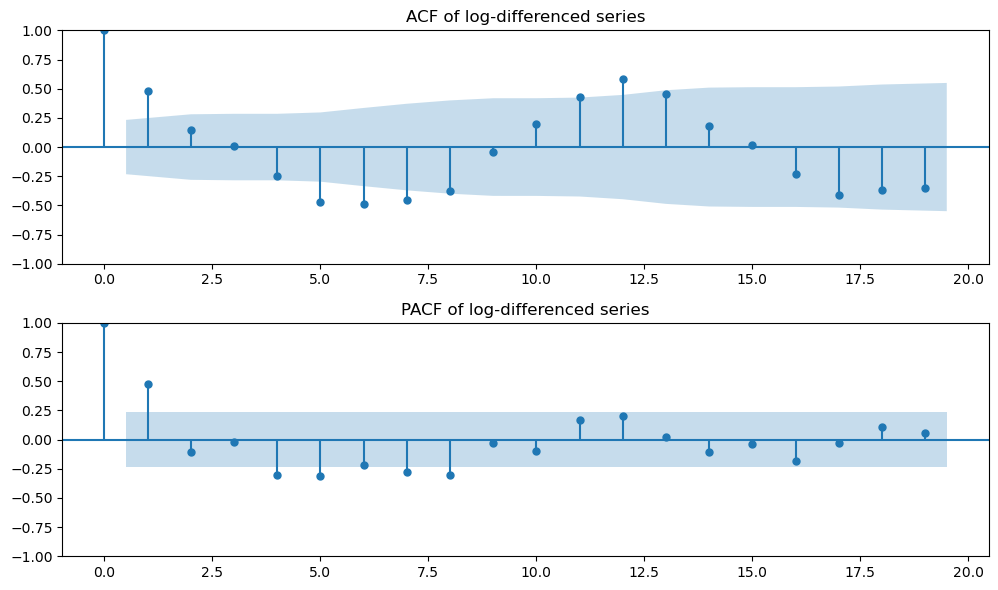

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(df[column], ax=axes[0])
axes[0].set_title("ACF of log-differenced series")

plot_pacf(df[column], ax=axes[1])
axes[1].set_title("PACF of log-differenced series")

plt.tight_layout()
plt.show()

## Variation playground

In [24]:
column = "values_log"

In [25]:
from modules import utils

df_forecast = df[[column]].copy()

# ARIMA baseline
df_forecast = utils.get_model_forecast(df_forecast, column, order=(1, 1, 1), horizon=96, forecast_exp=True)

# SARIMA candidates
df_forecast = utils.get_model_forecast(
    df_forecast, column, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), horizon=96, forecast_exp=True
)

df_forecast = utils.get_model_forecast(
    df_forecast, column, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), horizon=96, forecast_exp=True
)

df_forecast = pd.concat([
    df[['values']],
    df_forecast.drop(columns=[column]),
], axis=1)

df_forecast

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



,values,"ARIMA(1,1,1)","SARIMA(1,1,1)(1,1,1,12)","SARIMA(0,1,1)(0,1,1,12)"
2019-02-28 07:00:00+00:00,1681819.0,1.000000e+00,1.000000e+00,1.000000e+00
2019-03-31 07:00:00+00:00,2463585.0,1.681819e+06,1.681819e+06,1.681819e+06
...,...,...,...,...
2032-11-30 07:00:00+00:00,NaN,2.607084e+06,6.532697e+06,7.589978e+06
2032-12-31 07:00:00+00:00,NaN,2.607084e+06,5.101051e+06,5.878981e+06


## Choose best model

### Forecast plot

In [65]:
d = 1
D = 1
s = 12

idx_offset = d + D * s
idx_offset

13

In [66]:
x = df_forecast.iloc[idx_offset:]
fig = x.plot(color="variable")
fig.update_layout(hovermode="x unified")

In [67]:
df_forecast = x.copy()

### Metrics review

In [30]:
x = df_forecast.dropna()
x

,values,"ARIMA(1,1,1)","SARIMA(1,1,1)(1,1,1,12)","SARIMA(0,1,1)(0,1,1,12)"
2020-03-31 07:00:00+00:00,2308003.0,2.385136e+06,3.211094e+06,3.211094e+06
2020-04-30 07:00:00+00:00,2768076.0,2.327169e+06,2.986522e+06,3.149365e+06
...,...,...,...,...
2024-11-30 07:00:00+00:00,2952150.0,3.822857e+06,3.080492e+06,3.221662e+06
2024-12-31 07:00:00+00:00,2669105.0,2.503495e+06,2.231710e+06,2.333591e+06


In [31]:
real = x.pop("values")
real

2020-03-31 07:00:00+00:00    2308003.0
2020-04-30 07:00:00+00:00    2768076.0
                               ...    
2024-11-30 07:00:00+00:00    2952150.0
2024-12-31 07:00:00+00:00    2669105.0
Freq: ME, Name: values, Length: 58, dtype: float64

In [48]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Example metrics
metrics = {
    "rmse": root_mean_squared_error,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
}

In [49]:
d = {}
for k,v in metrics.items():
    metric = x.apply(lambda x: v(real, x))
    d[k] = metric
    
pd.DataFrame(d).style.background_gradient(cmap="RdYlGn_r", axis=0)

,rmse,mae,mape
"ARIMA(1,1,1)",415336.977396,340800.996076,0.111026
"SARIMA(1,1,1)(1,1,1,12)",303681.043802,240049.848636,0.080730
"SARIMA(0,1,1)(0,1,1,12)",317844.513421,262414.615965,0.086104


## Diagnostics to validate assumptions

### Model fit

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = order = (0, 1, 1)
P, D, Q, s = seasonal_order = (0, 1, 1, 12)

model = SARIMAX(df["values_log"], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

### Residuals

In [60]:
idx_offset = d + D * s

residuals = model_fit.resid[idx_offset:]
residuals

period
2020-03-31 00:00:00-07:00   -0.330229
2020-04-30 00:00:00-07:00   -0.129048
                               ...   
2024-11-30 00:00:00-07:00   -0.087364
2024-12-31 00:00:00-07:00    0.134335
Freq: ME, Length: 58, dtype: float64

### Assumptions
#### Autocorrelation

##### Plot

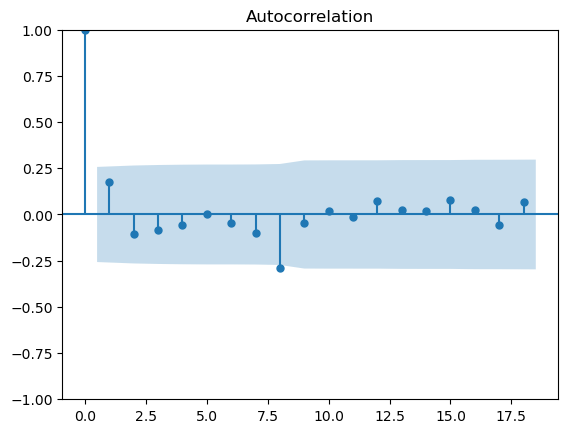

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

##### Test

In [62]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,9.930108,0.446646
20,12.156315,0.910591
30,21.133107,0.883680


#### Normality

##### Plot

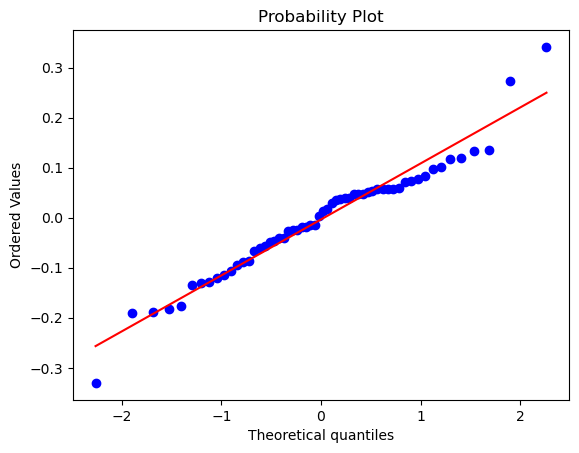

In [63]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

##### Test

In [64]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(4.754491302213924), pvalue=np.float64(0.09280584547820007))

#### Homoscedasticity

##### Plot

In [57]:
residuals.plot()

##### Test

In [58]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(11.473666113893277),
 np.float64(0.32182401566103563),
 1.1622454296611606,
 0.34608190037202663)